In [1]:
import matplotlib.pyplot as plt
from segments.utils import get_semantic_bitmap
from segments import SegmentsClient
from segments.huggingface import release2dataset
from datasets import load_dataset

import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

c:\Users\dskon\anaconda3\envs\compvision\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
dataset_identifier = "dskong07/chargers-full"
name = "chargers-labeled-full-v0.1"
release_name = "chargers-labeled-full-v0.1"
hub_model_id = "segformer-b0-finetuned-segments-chargers-2-15"
hf_dataset_identifier = f"dskong07/chargers-full-v0.1"
id2label = {0: 'unlabeled', 1: 'screen', 2: 'body', 3: 'cable', 4: 'plug', 5: 'void-background'}
label2id = {v: k for k, v in id2label.items()}

In [3]:
palette = [
    [0, 0, 0],  # unlabeled
    [216, 0, 24], #screen
    [255, 255, 0],  #body
    [125, 46, 141], # cable
    [118, 171, 47], # plug
    [125, 0, 225] #void-background
]

### Importing Dataset

In [4]:

from datasets import load_dataset

ds = load_dataset(hf_dataset_identifier)

### Importing model

In [5]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

processor = SegformerImageProcessor.from_pretrained("nvidia/mit-b0")
model = SegformerForSemanticSegmentation.from_pretrained(f"{'dskong07'}/{hub_model_id}")

c:\Users\dskon\anaconda3\envs\compvision\Lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


### Helpers

In [6]:
import numpy as np


# parses the matrix of (n,n) pixels identified by the model which have been categorized into classifiers (e.g 0-5 corresponding to the classification's ID, e.g. 1 = screen), and modifies each classification into a length 3 RGB value given by the palette.  
def get_seg_overlay(image, seg):
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(palette)
  for label, color in enumerate(palette): 
      color_seg[seg == label, :] = color

  # Show image + mask
  img = np.array(image) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  return img

In [7]:

#overlays the raw, original image with the transformed RGB mask generated by the inference model.

def get_overlays(path, is_web = True):

    #url = "https://media.wired.com/photos/6650c3c556be637959104b4c/master/w_2240,c_limit/How-Many-EV-Chargers-Do-We-Need--Gear-GettyImages-1242853407.jpg"
    if is_web:
        image = Image.open(requests.get(path, stream=True).raw)
    else:
        image = Image.open(path)

    image_segmentator = pipeline(
        "image-segmentation",
        model=f"{'dskong07'}/{hub_model_id}",  # Change with your model name
    )
    results = image_segmentator(image)


    image_array = np.array(image)

    segmentation_map = np.zeros_like(image_array)

    for result in results:

        mask = np.array(result["mask"])

        label = result["label"]

        label_index = list(id2label.values()).index(label)

        color = palette[label_index]

        for c in range(3):

            segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])
    return image, image_array, segmentation_map

### Examples of inference on unseen images, both web-based and local.

Device set to use cpu


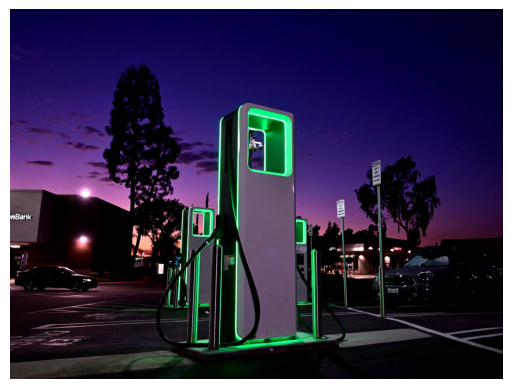

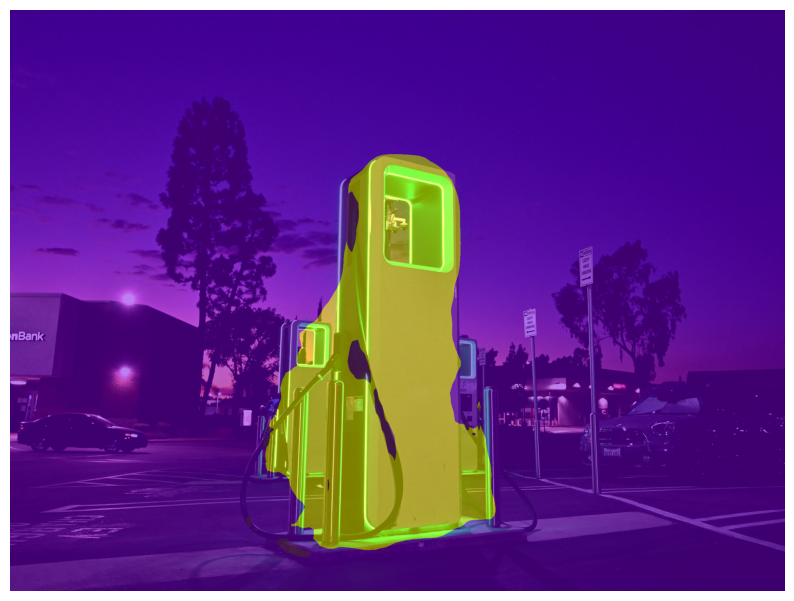

In [18]:
url = 'https://media.wired.com/photos/6650c3c556be637959104b4c/master/w_2240,c_limit/How-Many-EV-Chargers-Do-We-Need--Gear-GettyImages-1242853407.jpg'
image, image_array, segmentation_map = get_overlays(url)

plt.imshow(image)

plt.axis("off")

plt.show()
plt.figure(figsize=(10, 10))

plt.imshow(image_array)

plt.imshow(segmentation_map, alpha=0.5)

plt.axis("off")

plt.show()

### For potential live demonstration use:

In [ ]:
import glob

jpgFilenamesList = glob.glob('example_data/*.jpg')

['example_data\\default-trivialseg.jpg',
 'example_data\\example.jpg',
 'example_data\\example2.jpg']

Device set to use cpu


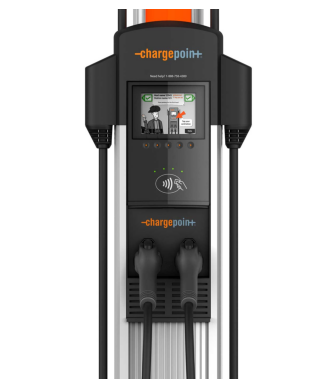

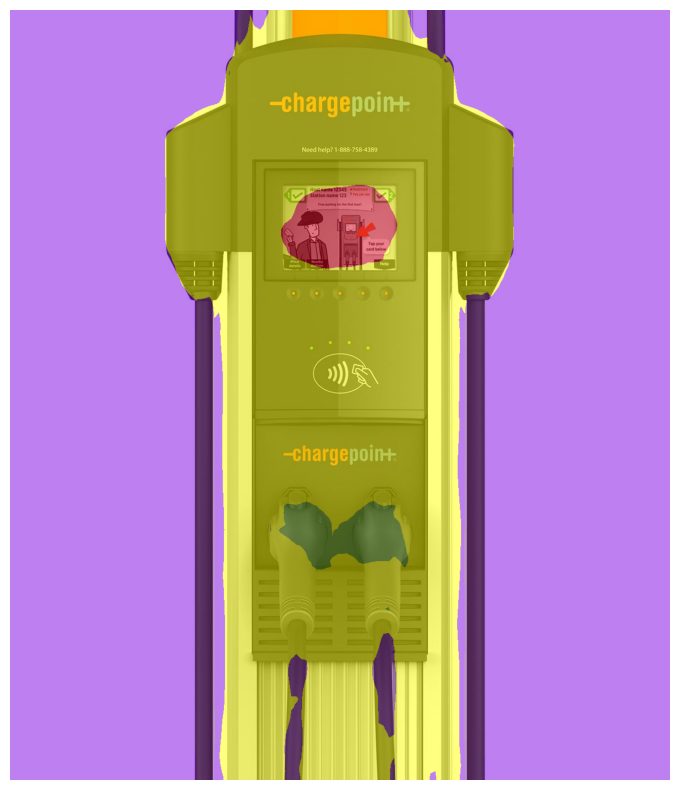

Device set to use cpu


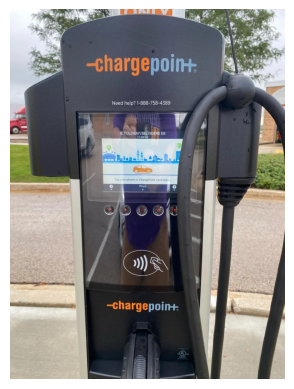

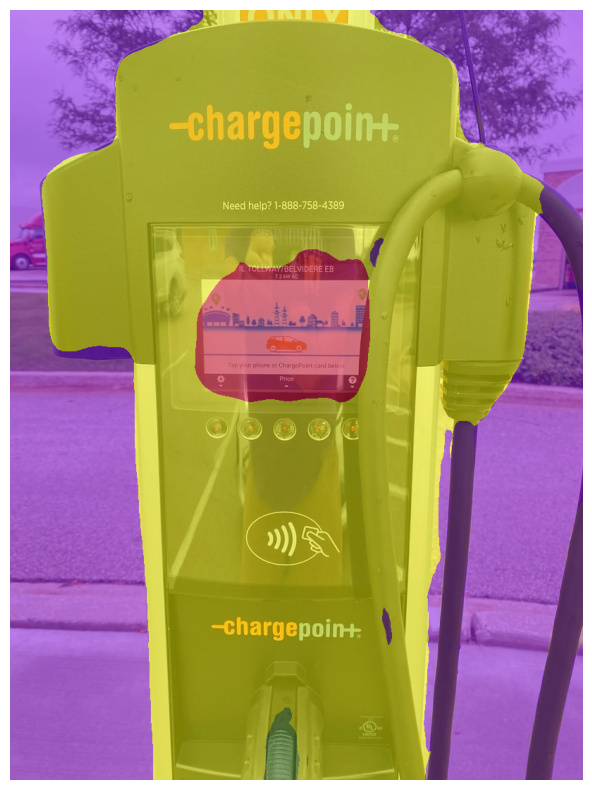

Device set to use cpu


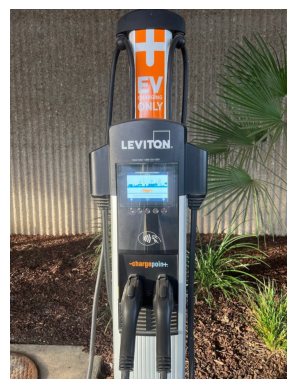

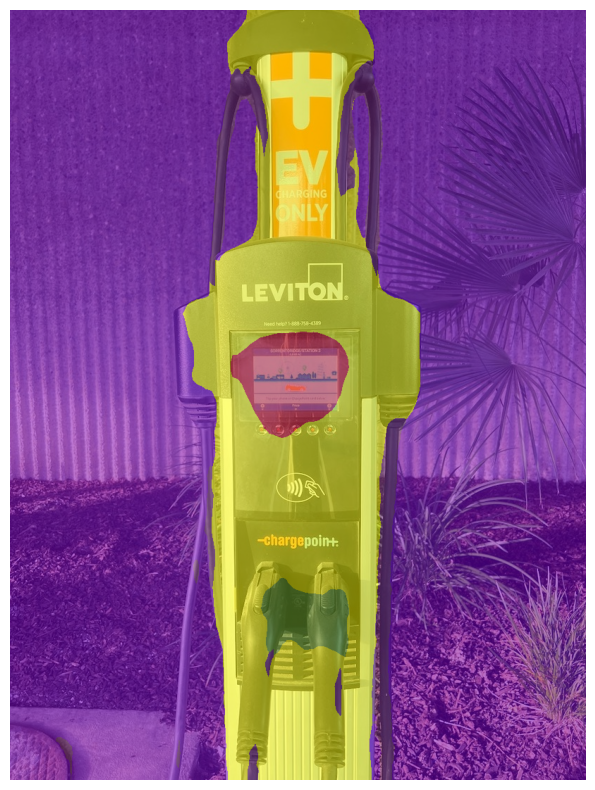

In [17]:
for i in range(len(jpgFilenamesList)):

    path = jpgFilenamesList[i]

    image, image_array, segmentation_map = get_overlays(path, is_web = False)

    plt.imshow(image)

    plt.axis("off")

    plt.show()
    plt.figure(figsize=(10, 10))

    plt.imshow(image_array)

    plt.imshow(segmentation_map, alpha=0.5)

    plt.axis("off")

    plt.show()